# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10,6)

from scipy import stats

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [2]:
# loading the data:

df = pd.read_csv('../data/Wholesale customers data.csv')
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

#### a) What does each column mean?
1. FRESH: annual spending (m.u.) on fresh products (Continuous);
1. MILK: annual spending (m.u.) on milk products (Continuous);
1. GROCERY: annual spending (m.u.)on grocery products (Continuous);
1. FROZEN: annual spending (m.u.)on frozen products (Continuous)
1. DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
1. DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
1. CHANNEL: customers Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal)
1. REGION: customers Region - Lisbon, Oporto or Other (Nominal)

In [3]:
# b) Any categorical data to convert?
# There are only 2 categorical columns but they are converted to ordinals. This means, all columns are numerical.

df.select_dtypes(include='number').head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
# c) Any missing data to remove?
# There's no missing data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


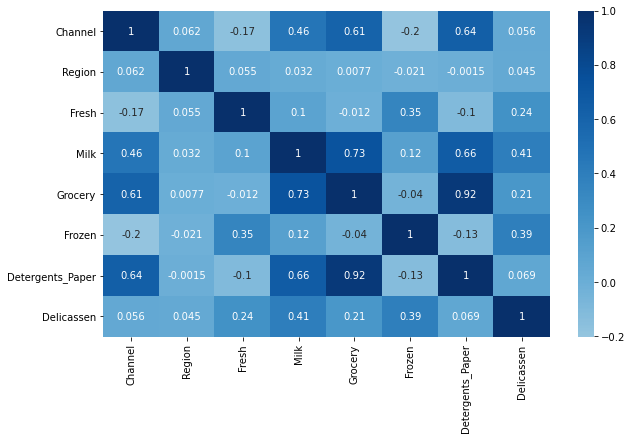

In [5]:
# d) Column collinearity - any high correlations?
# There's only one high correlation: Grocery - Detergents_Paper. The next step would be to remove one column to avoid collinearity.

_ = sns.heatmap(df.corr(), cmap='Blues', annot=True, center=0)

In [6]:
# e) Descriptive statistics - any outliers to remove?

df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [7]:
products = [column for column in df.columns][2:]

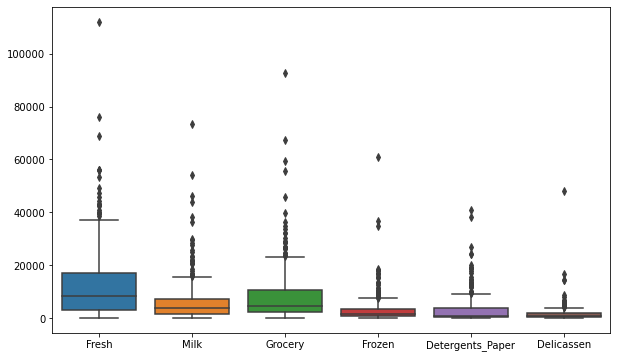

In [8]:
_ = sns.boxplot(data=df[products])

# 'Fresh' and 'Milk' are the columns with the highest number of outliers.

In [9]:
# f) Column-wise data distribution - is the distribution skewed?

# As we can see in the distplots below, the distribution of all columns is right-skewed. This means we should standardize the dataframe. It is also confirmed in the below cell, as all the values are greater than 1 (highly skewed).

In [10]:
stats.skew(df[products])

array([ 2.55258269,  4.03992212,  3.57518722,  5.88782573,  3.61945758,
       11.11353365])

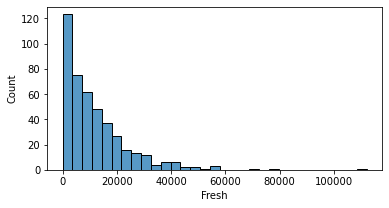

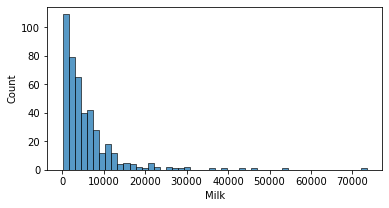

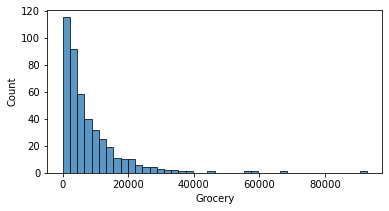

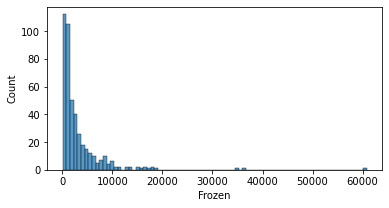

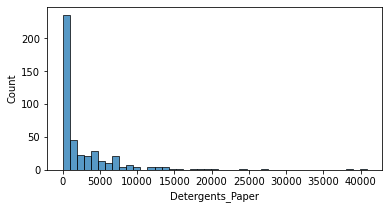

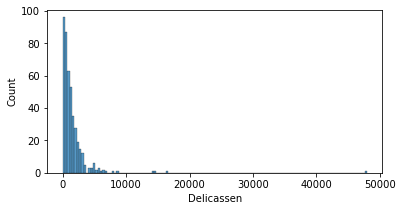

In [11]:
for product in products:
    plt.figure(figsize=(6,3))
    sns.histplot(df[product])

In [12]:
# The Pareto principle (80/20 rule) states that roughly 20% of the customers account for 80% of the typical retail sales

# Step 1: calculate the total product sales
df['Total Sales'] = df[products].sum(axis=1)

df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total Sales
0,2,3,12669,9656,7561,214,2674,1338,34112
1,2,3,7057,9810,9568,1762,3293,1776,33266
2,2,3,6353,8808,7684,2405,3516,7844,36610
3,1,3,13265,1196,4221,6404,507,1788,27381
4,2,3,22615,5410,7198,3915,1777,5185,46100


In [13]:
# Step 2: calculate the 80% of the total sales

sales_80 = df['Total Sales'].sum() * 0.8
sales_80

11695600.0

In [14]:
# Step 3: calculate the 20% of the customers and their total sales

customers_20 = int(len(df) * 0.20)
customers_20

88

In [15]:
top_sales_df = df.sort_values(by='Total Sales', ascending=False)[:customers_20]
top_sales_df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total Sales
85,2,3,16117,46197,92780,1026,40827,2944,199891
47,2,3,44466,54259,55571,7782,24171,6465,192714
181,1,3,112151,29627,18148,16745,4948,8550,190169
183,1,3,36847,43950,20170,36534,239,47943,185683
61,2,3,35942,38369,59598,3254,26701,2017,165881
...,...,...,...,...,...,...,...,...,...
304,2,2,161,7460,24773,617,11783,2410,47204
240,1,1,22096,3575,7041,11422,343,2564,47041
377,1,3,38793,3154,2648,1034,96,1242,46967
36,1,3,29955,4362,5428,1729,862,4626,46962


In [16]:
# Step 4: calculate the 20% of the total sales that account for the top 20% customers

sales_20 = top_sales_df['Total Sales'].sum()
sales_20

6272473

In [17]:
# Step 5: is the Pareto principle verified?

if sales_80 > sales_20:
    print(f'The Pareto principle is not verified. The revenue accrued by the 20% of the customers ({round(sales_20)}) is not higher or equal than the revenue accrued by the 80% of the customers ({round(sales_80)}).')
else:
    print(f'The Pareto principle is verified. The revenue accrued by the 20% of the customers ({round(sales_20)}) is higher or equal than the revenue accrued by the 80% of the customers ({round(sales_80)}).')

The Pareto principle is not verified. The revenue accrued by the 20% of the customers (6272473) is not higher or equal than the revenue accrued by the 80% of the customers (11695600).


In [18]:
# CONCLUSIONS

# Categorical data: the best would be to encode them
# There's no missing data
# There's only one high correlation: Grocery - Detergents_Paper. The next step would be to remove one column to avoid collinearity. However, clustering is not badly affected by collinearity and we will actually need all columns later on, so we will not delete it.
# 'Fresh' and 'Milk' are the columns with the highest number of outliers, although all products have some outliers.
# # The distribution of all columns is right-skewed. This means we should standardize the dataframe.
# The Pareto principle is not verified

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [19]:
# 1. Removing outliers

def remove_outliers(df):
    for column in df:
        q25 = df[column].describe()[4]
        q75 = df[column].describe()[6]
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        not_outliers = [x for x in df[column] if x > lower and x < upper]
        df = df[df[column].isin(not_outliers)]
    return df

In [20]:
df = remove_outliers(df)
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total Sales
0,2,3,12669,9656,7561,214,2674,1338,34112
1,2,3,7057,9810,9568,1762,3293,1776,33266
3,1,3,13265,1196,4221,6404,507,1788,27381
5,2,3,9413,8259,5126,666,1795,1451,26710
6,2,3,12126,3199,6975,480,3140,545,26465
...,...,...,...,...,...,...,...,...,...
432,1,3,21117,1162,4754,269,1328,395,29025
433,1,3,1982,3218,1493,1541,356,1449,10039
434,1,3,16731,3922,7994,688,2371,838,32544
438,1,3,10290,1981,2232,1038,168,2125,17834


In [21]:
# 2. Renaming ordinal numbers per categories, and then encoding

df['Channel'] = df['Channel'].replace(1,'Horeca').replace(2,'Retail')
df['Region'] = df['Region'].replace(1,'Lisbon').replace(2,'Oporto').replace(3,'Other Region')

In [22]:
df = pd.get_dummies(df, drop_first=True)
df

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total Sales,Channel_Retail,Region_Oporto,Region_Other Region
0,12669,9656,7561,214,2674,1338,34112,1,0,1
1,7057,9810,9568,1762,3293,1776,33266,1,0,1
3,13265,1196,4221,6404,507,1788,27381,0,0,1
5,9413,8259,5126,666,1795,1451,26710,1,0,1
6,12126,3199,6975,480,3140,545,26465,1,0,1
...,...,...,...,...,...,...,...,...,...,...
432,21117,1162,4754,269,1328,395,29025,0,0,1
433,1982,3218,1493,1541,356,1449,10039,0,0,1
434,16731,3922,7994,688,2371,838,32544,0,0,1
438,10290,1981,2232,1038,168,2125,17834,0,0,1


# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
sc = StandardScaler()
customers_scale = sc.fit_transform(df)

# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [25]:
from sklearn.cluster import KMeans

In [26]:
inertias = [KMeans(k).fit(customers_scale).inertia_ for k in range(2,10)]
inertias

[2167.1282575424543,
 1856.3510183833823,
 1557.2179431678119,
 1413.3350189447247,
 1327.1466383309246,
 1213.927546730127,
 1141.8521737552485,
 1076.1046930043333]

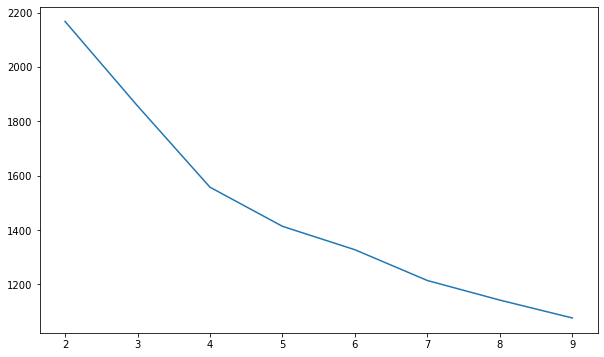

In [27]:
_ = plt.plot(range(2,10), inertias)
# By plotting the inertias, we can see there's no clear elbow. This means there are no clear clusters.

In [28]:
cl = KMeans(n_clusters=2)

In [29]:
cl.fit(customers_scale)

KMeans(n_clusters=2)

In [30]:
clusters = cl.predict(customers_scale)

In [31]:
df['labels'] = cl.labels_

Count the values in `labels`.

In [32]:
df['labels'].value_counts()

0    222
1     92
Name: labels, dtype: int64

# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [33]:
from sklearn.cluster import DBSCAN

In [34]:
dbscan = DBSCAN(eps=0.5)

In [35]:
dbscan.fit(customers_scale)

DBSCAN()

In [36]:
df['labels_DBSCAN'] = dbscan.labels_

Count the values in `labels_DBSCAN`.

In [37]:
df['labels_DBSCAN'].value_counts()

-1    297
 0      7
 1      5
 2      5
Name: labels_DBSCAN, dtype: int64

# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

In [ ]:
# Your code here:


Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

In [ ]:
# Your code here:


Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

In [ ]:
# Your code here:

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [ ]:
# Your code here:


Which algorithm appears to perform better?

In [ ]:
# Your observations here

# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here